In [65]:
import numpy as np;
import matplotlib
from matplotlib import pyplot
b=np.array([1,2,3,4,5,6,6,7,7,8,9])
unique_b,counts=np.unique(b,return_counts=True)
print(f"Unique  data:{b}")
print(f"counts:{counts}")

Unique  data:[1 2 3 4 5 6 6 7 7 8 9]
counts:[1 1 1 1 1 2 2 1 1]


In [66]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:


# Install required packages first
# !pip install kaggle kagglehub pandas pyunpack patool

import os
import shutil
import zipfile
import tempfile
from pathlib import Path
from google.colab import files as colab_files
import kagglehub

# ============================================
# SIMPLE KAGGLE TO DRIVE DOWNLOADER
# ============================================

def download_kaggle_to_drive(kaggle_path, drive_folder, unzip=True, cleanup=True):
    """
    Simple function to download Kaggle dataset to Google Drive

    Args:
        kaggle_path: Kaggle dataset path (e.g., "username/dataset-name" or full URL)
        drive_folder: Google Drive destination folder path
        unzip: Whether to unzip files automatically
        cleanup: Whether to delete temporary files

    Returns:
        Path to downloaded files in Google Drive
    """

    print(f"🚀 Starting download: {kaggle_path}")
    print(f"📁 Destination: {drive_folder}")

    # Step 1: Extract kaggle handle from input
    def get_kaggle_handle(input_path):
        """Extract kaggle handle from various input formats"""
        import re

        # Remove any query parameters
        input_path = input_path.split('?')[0]

        # Pattern to match kaggle dataset URLs
        patterns = [
            r'kaggle\.com/(?:datasets|competitions|codes)/([a-zA-Z0-9\-_]+/[a-zA-Z0-9\-_]+)',
            r'^([a-zA-Z0-9\-_]+/[a-zA-Z0-9\-_]+)$'
        ]

        for pattern in patterns:
            match = re.search(pattern, input_path)
            if match:
                return match.group(1)

        # If no pattern matches, return as-is
        return input_path

    # Get clean kaggle handle
    kaggle_handle = get_kaggle_handle(kaggle_path)
    print(f"🔍 Kaggle handle: {kaggle_handle}")

    # Step 2: Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive mounted")

        # Ensure drive folder is in the correct path
        if not drive_folder.startswith('/content/drive'):
            drive_folder = f"/content/drive/MyDrive/{drive_folder.lstrip('/')}"
    except ImportError:
        print("⚠️  Not in Google Colab - ensure drive_folder is correct path")

    # Create destination folder
    os.makedirs(drive_folder, exist_ok=True)
    print(f"📁 Created destination folder: {drive_folder}")

    # Step 3: Download from Kaggle
    try:
        print("⬇️  Downloading from Kaggle...")
        download_path = kagglehub.dataset_download(kaggle_handle)
        print(f"✅ Downloaded to: {download_path}")
    except Exception as e:
        print(f"❌ Kaggle download failed: {e}")

        # Try alternative method
        try:
            import subprocess
            import tempfile

            print("🔄 Trying alternative download method...")
            temp_dir = tempfile.mkdtemp()

            # Use kaggle CLI
            result = subprocess.run(
                ["kaggle", "datasets", "download", "-d", kaggle_handle, "-p", temp_dir],
                capture_output=True,
                text=True
            )

            if result.returncode == 0:
                # Find the downloaded file
                files = os.listdir(temp_dir)
                zip_files = [f for f in files if f.endswith('.zip')]

                if zip_files:
                    download_path = os.path.join(temp_dir, zip_files[0])
                    print(f"✅ Downloaded zip file: {download_path}")
                else:
                    download_path = temp_dir
                    print(f"✅ Downloaded to directory: {download_path}")
            else:
                print(f"❌ Alternative method failed: {result.stderr}")
                return None

        except Exception as e2:
            print(f"❌ All download methods failed: {e2}")
            return None

    # Step 4: Process and copy files
    print("\n📊 Processing files...")

    def copy_files(source, destination):
        """Copy files from source to destination"""
        if os.path.isfile(source):
            # Single file
            shutil.copy2(source, destination)
            return 1
        else:
            # Directory
            count = 0
            for item in os.listdir(source):
                source_path = os.path.join(source, item)
                dest_path = os.path.join(destination, item)

                if os.path.isdir(source_path):
                    shutil.copytree(source_path, dest_path, dirs_exist_ok=True)
                    # Count files in subdirectory
                    for root, dirs, files in os.walk(source_path):
                        count += len(files)
                else:
                    shutil.copy2(source_path, dest_path)
                    count += 1
            return count

    # Check if download is a zip file
    if os.path.isfile(download_path) and download_path.endswith('.zip') and unzip:
        print(f"📦 Extracting zip file: {os.path.basename(download_path)}")

        # Create extraction directory
        extract_dir = os.path.join(drive_folder, "extracted")
        os.makedirs(extract_dir, exist_ok=True)

        # Extract zip
        try:
            with zipfile.ZipFile(download_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

            # Count extracted files
            extracted_count = 0
            for root, dirs, files in os.walk(extract_dir):
                extracted_count += len(files)

            print(f"✅ Extracted {extracted_count} files to: {extract_dir}")

            # Move files from extracted folder to main folder
            for item in os.listdir(extract_dir):
                source = os.path.join(extract_dir, item)
                dest = os.path.join(drive_folder, item)

                if os.path.isdir(source):
                    shutil.move(source, dest)
                else:
                    shutil.move(source, dest)

            # Remove empty extract directory
            os.rmdir(extract_dir)

        except Exception as e:
            print(f"❌ Failed to extract zip: {e}")
            print("📄 Copying zip file as-is...")
            shutil.copy2(download_path, os.path.join(drive_folder, os.path.basename(download_path)))

    else:
        # Copy files directly
        if os.path.isfile(download_path):
            # Single file
            shutil.copy2(download_path, os.path.join(drive_folder, os.path.basename(download_path)))
            print(f"✅ Copied file: {os.path.basename(download_path)}")
        else:
            # Directory
            copied_count = copy_files(download_path, drive_folder)
            print(f"✅ Copied {copied_count} files")

    # Step 5: Cleanup
    if cleanup:
        try:
            if os.path.isfile(download_path):
                os.remove(download_path)
            else:
                shutil.rmtree(download_path)
            print("🧹 Cleaned up temporary files")
        except Exception as e:
            print(f"⚠️  Could not clean up temp files: {e}")

    # Step 6: Show summary
    print("\n" + "="*50)
    print("✅ DOWNLOAD COMPLETE!")
    print("="*50)

    # List files in destination
    print(f"\n📁 Files in {drive_folder}:")
    files_list = os.listdir(drive_folder)
    for i, file in enumerate(files_list[:20]):  # Show first 20 files
        file_path = os.path.join(drive_folder, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            print(f"  {i+1:2d}. {file} ({size:,} bytes)")
        else:
            print(f"  {i+1:2d}. {file}/ (folder)")

    if len(files_list) > 20:
        print(f"  ... and {len(files_list) - 20} more items")

    print(f"\n📍 Total files/folders: {len(files_list)}")

    return drive_folder

# ============================================
# UPLOAD FROM COMPUTER FUNCTION
# ============================================

def upload_to_drive(local_folder=None, drive_folder=None):
    """
    Upload files from local computer to Google Drive

    Args:
        local_folder: If None, upload via Colab file dialog
        drive_folder: Google Drive destination folder
    """

    print("💻 UPLOAD FROM COMPUTER")
    print("="*50)

    # Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        if drive_folder and not drive_folder.startswith('/content/drive'):
            drive_folder = f"/content/drive/MyDrive/{drive_folder.lstrip('/')}"
    except ImportError:
        print("⚠️  Not in Google Colab")
        if not drive_folder:
            drive_folder = input("Enter Google Drive folder path: ").strip()

    if not drive_folder:
        drive_folder = "/content/drive/MyDrive/Uploads"

    os.makedirs(drive_folder, exist_ok=True)
    print(f"📁 Destination: {drive_folder}")

    uploaded_files = []

    if local_folder:
        # Upload from specified local folder
        if os.path.exists(local_folder):
            print(f"📤 Uploading from local folder: {local_folder}")

            for item in os.listdir(local_folder):
                source = os.path.join(local_folder, item)
                dest = os.path.join(drive_folder, item)

                if os.path.isfile(source):
                    shutil.copy2(source, dest)
                    uploaded_files.append(item)
                    print(f"  ✅ {item}")
                else:
                    shutil.copytree(source, dest, dirs_exist_ok=True)
                    uploaded_files.append(f"{item}/")
                    print(f"  ✅ {item}/")
        else:
            print(f"❌ Local folder not found: {local_folder}")
            return None

    else:
        # Upload via Colab file dialog
        try:
            print("📤 Please select files to upload...")
            uploaded = colab_files.upload()

            if uploaded:
                for filename, content in uploaded.items():
                    dest_path = os.path.join(drive_folder, filename)

                    # Save file
                    with open(dest_path, 'wb') as f:
                        f.write(content)

                    uploaded_files.append(filename)
                    print(f"  ✅ {filename}")
            else:
                print("⚠️  No files selected")
                return None

        except Exception as e:
            print(f"❌ Upload failed: {e}")
            return None

    print(f"\n✅ Uploaded {len(uploaded_files)} files to: {drive_folder}")
    return drive_folder

# ============================================
# COMBINED FUNCTION WITH MENU
# ============================================

def data_transfer_tool():
    """
    Main function with menu to choose between Kaggle download or local upload
    """

    print("""
    ╔═══════════════════════════════════════╗
    ║       DATA TRANSFER TOOL              ║
    ║   Kaggle → Drive  or  Local → Drive   ║
    ╚═══════════════════════════════════════╝
    """)

    while True:
        print("\n" + "="*50)
        print("MAIN MENU")
        print("="*50)
        print("1. 📥 Download from Kaggle to Google Drive")
        print("2. 💻 Upload from computer to Google Drive")
        print("3. 🚪 Exit")

        choice = input("\nSelect option (1-3): ").strip()

        if choice == "1":
            print("\n📥 KAGGLE TO GOOGLE DRIVE")
            print("-"*30)

            # Get kaggle path
            print("\nEnter Kaggle dataset (any format):")
            print("Examples:")
            print("  - https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024")
            print("  - jekiwantaufik/west-java-2014-2024")

            kaggle_path = input("\nKaggle dataset: ").strip()

            if not kaggle_path:
                print("❌ No input provided")
                continue

            # Get drive folder
            default_drive = "/content/drive/MyDrive/Kaggle_Datasets"
            drive_folder = input(f"\nGoogle Drive folder [{default_drive}]: ").strip()
            if not drive_folder:
                drive_folder = default_drive

            # Options
            unzip_choice = input("\nUnzip files? (yes/no) [yes]: ").strip().lower()
            unzip = not unzip_choice or unzip_choice in ['yes', 'y', '1']

            cleanup_choice = input("Cleanup temporary files? (yes/no) [yes]: ").strip().lower()
            cleanup = not cleanup_choice or cleanup_choice in ['yes', 'y', '1']

            # Download
            download_kaggle_to_drive(kaggle_path, drive_folder, unzip, cleanup)

        elif choice == "2":
            print("\n💻 UPLOAD FROM COMPUTER")
            print("-"*30)

            # Get source
            print("\nChoose source:")
            print("1. Upload via file dialog (Colab)")
            print("2. Specify local folder path")

            source_choice = input("\nSelect (1 or 2): ").strip()

            if source_choice == "1":
                local_folder = None
            elif source_choice == "2":
                local_folder = input("\nEnter local folder path: ").strip()
                if not os.path.exists(local_folder):
                    print(f"❌ Folder not found: {local_folder}")
                    continue
            else:
                print("❌ Invalid choice")
                continue

            # Get drive folder
            default_drive = "/content/drive/MyDrive/Uploads"
            drive_folder = input(f"\nGoogle Drive folder [{default_drive}]: ").strip()
            if not drive_folder:
                drive_folder = default_drive

            # Upload
            upload_to_drive(local_folder, drive_folder)

        elif choice == "3":
            print("👋 Goodbye!")
            break

        else:
            print("❌ Invalid choice")

        input("\nPress Enter to continue...")

# ============================================
# QUICK USAGE EXAMPLES
# ============================================

# Example 1: Direct Kaggle download
def example_kaggle():
    """Example: Download a Kaggle dataset"""
    download_kaggle_to_drive(
        kaggle_path="https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024",
        drive_folder="/content/drive/MyDrive/Datasets/WestJava",
        unzip=True,
        cleanup=True
    )

# Example 2: Direct upload
def example_upload():
    """Example: Upload from computer"""
    upload_to_drive(
        local_folder=None,  # Will use Colab file dialog
        drive_folder="/content/drive/MyDrive/Uploads"
    )

# Example 3: Upload specific folder
def example_upload_folder():
    """Example: Upload specific folder"""
    upload_to_drive(
        local_folder="/path/to/your/local/folder",
        drive_folder="/content/drive/MyDrive/MyProject/Data"
    )

# ============================================
# RUN THE TOOL
# ============================================

if __name__ == "__main__":
    # Run the interactive tool
    data_transfer_tool()

    # Or use directly:
    # download_kaggle_to_drive("username/dataset", "/content/drive/MyDrive/MyFolder")



    ╔═══════════════════════════════════════╗
    ║       DATA TRANSFER TOOL              ║
    ║   Kaggle → Drive  or  Local → Drive   ║
    ╚═══════════════════════════════════════╝
    

MAIN MENU
1. 📥 Download from Kaggle to Google Drive
2. 💻 Upload from computer to Google Drive
3. 🚪 Exit

Select option (1-3): 1

📥 KAGGLE TO GOOGLE DRIVE
------------------------------

Enter Kaggle dataset (any format):
Examples:
  - https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024
  - jekiwantaufik/west-java-2014-2024

Kaggle dataset: https://www.kaggle.com/datasets/ilknuricke/neurohackinginrimages

Google Drive folder [/content/drive/MyDrive/Kaggle_Datasets]: /content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1

Unzip files? (yes/no) [yes]: yes
Cleanup temporary files? (yes/no) [yes]: yes
🚀 Starting download: https://www.kaggle.com/datasets/ilknuricke/neurohackinginrimages
📁 Destination: /content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1
🔍 Kaggle handle: ilknuricke/neurohack

Text(0.5, 1.0, '2D Image')

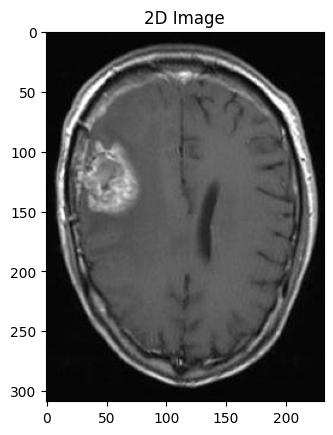

In [67]:
dataset_path='/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1'
image_path='/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y701.jpg'
import matplotlib.pyplot as plt
image=plt.imread(image_path)
plt.imshow(image)
plt.title("2D Image")


Type of image_1: <class 'str'>
First 100 chars of image_1: /content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y701.jpg


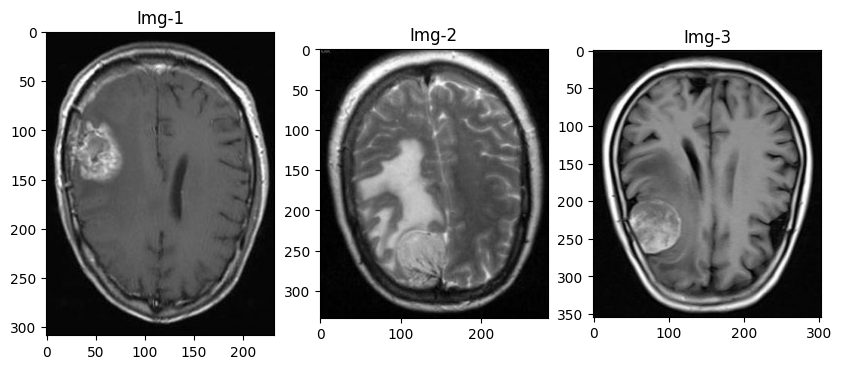

In [68]:
import matplotlib
from matplotlib import pyplot as plt;
image_1='/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y701.jpg'
image_2='/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y702.jpg'
image_3='/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y703.jpg'
# Convert string images to numpy arrays first
import numpy as np

# Check what type of data you have
print(f"Type of image_1: {type(image_1)}")
print(f"First 100 chars of image_1: {str(image_1)[:100]}")

# If images are file paths/strings, load them properly
try:
    import matplotlib.pyplot as plt
    from PIL import Image

    # Load images if they are file paths
    if isinstance(image_1, str):
        image_1 = np.array(Image.open(image_1).convert('L'))
    if isinstance(image_2, str):
        image_2 = np.array(Image.open(image_2).convert('L'))
    if isinstance(image_3, str):
        image_3 = np.array(Image.open(image_3).convert('L'))

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(image_1, cmap='gray')
    axes[0].set_title("Img-1")
    axes[1].imshow(image_2, cmap='gray')
    axes[1].set_title("Img-2")
    axes[2].imshow(image_3, cmap='gray')
    axes[2].set_title("Img-3")

except ImportError:
    print("Install PIL/Pillow: pip install Pillow")


image_1 is not a string, it is: <class 'numpy.ndarray'>


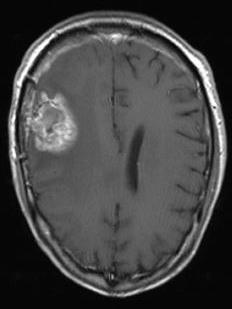

In [69]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

if isinstance(image_1, str):
    image = cv2.imread(image_1, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        resized_image = cv2.resize(image, (500, 500))
        cv2_imshow(resized_image)
        print("Image loaded successfully")
    else:
        print("Failed to load image from path:", image_1)
else:
    print("image_1 is not a string, it is:", type(image_1))
    cv2_imshow(image_1)

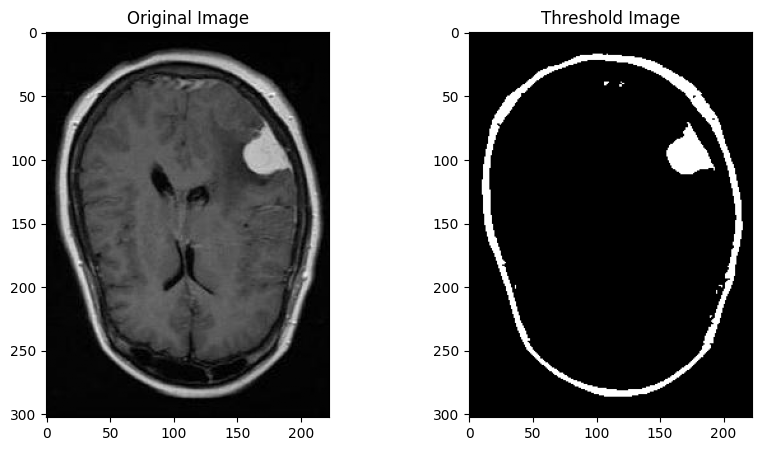

In [70]:

import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Read image
image1 = cv2.imread('/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y710.jpg', cv2.IMREAD_GRAYSCALE)

# Apply threshold
_, threshold_image = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)

# Show with matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(threshold_image, cmap='gray')
axes[1].set_title("Threshold Image")  # Fixed: changed axes[0] to axes[1]
plt.show()




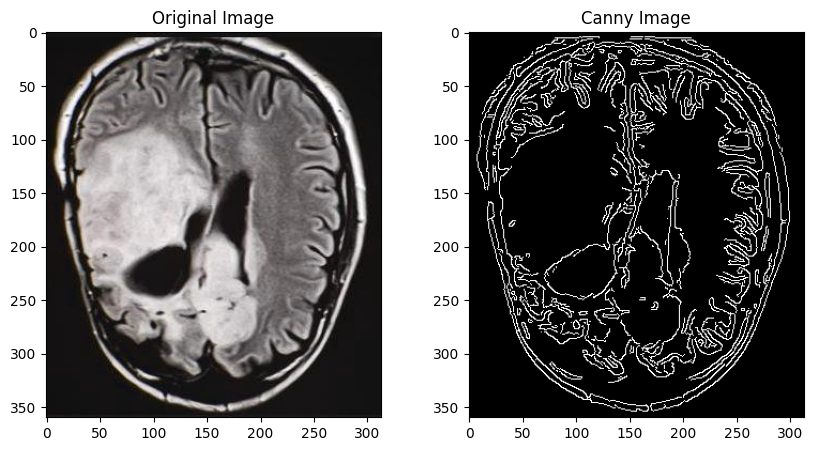

In [71]:
##Edge detection using opencv
img=cv2.imread('/content/drive/MyDrive/Health_Image_Dataset/Brain_Tumour/Dataset1/Brain scans/Tumor/TEST/y704.jpg')
edge=cv2.Canny(img,100,200)

# Show with matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(edge, cmap='gray')
axes[1].set_title("Canny Image")  # Fixed: changed axes[0] to axes[1]
plt.show()

In [72]:
!pip install pydicom

In [73]:
import pydicom
import matplotlib.pyplot as plt;


Image shape: (21, 672, 548)


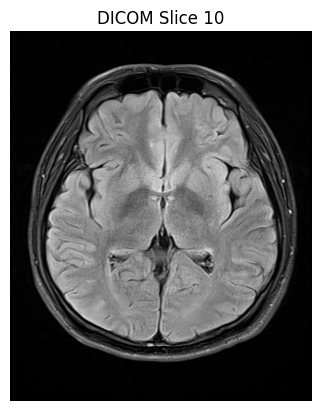

In [74]:
import pydicom
import matplotlib.pyplot as plt

dcm = pydicom.dcmread('/content/drive/MyDrive/DCM_Image/IMG-0002-00001.dcm')
img = dcm.pixel_array

print(f"Image shape: {img.shape}")

# If it's a 3D volume (multiple slices), show one slice
if len(img.shape) == 3:
    # Show middle slice
    middle_slice = img.shape[0] // 2
    plt.imshow(img[middle_slice], cmap='gray')
    plt.title(f'DICOM Slice {middle_slice}')
    plt.axis('off')
    plt.show()
else:
    plt.imshow(img, cmap='gray')
    plt.title('DICOM Image')
    plt.axis('off')
    plt.show()

In [75]:
print(f"patiens-Id:{dcm.PatientID}")
print(f"study Date:{dcm.StudyDate}")
print(f"Patient Name:{dcm.PatientName}")
print(f"StudyTime:{dcm.StudyTime}")

patiens-Id:Ultra_fast_Brain
study Date:20240808
Patient Name:Ultra_fast_Brain
StudyTime:172451.800000


Using pixel_array directly (no RescaleSlope/Intercept found)
Image shape: (21, 672, 548)


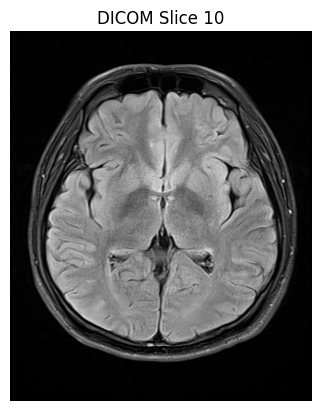

In [76]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt

dcm = pydicom.dcmread('/content/drive/MyDrive/DCM_Image/IMG-0002-00001.dcm')
img = dcm.pixel_array
save_path='/content/drive/MyDrive/DCM_Image'
# Check if RescaleSlope and RescaleIntercept exist
if hasattr(dcm, 'RescaleSlope') and hasattr(dcm, 'RescaleIntercept'):
    image = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    image=np.clip(image,-200,200)
    np.save(save_path,image)
else:
    # Use default values if attributes don't exist
    image = dcm.pixel_array
    print("Using pixel_array directly (no RescaleSlope/Intercept found)")

print(f"Image shape: {image.shape}")

if len(image.shape) == 3:
    middle_slice = image.shape[0] // 2
    plt.imshow(image[middle_slice], cmap='gray')
    plt.title(f'DICOM Slice {middle_slice}')
else:
    plt.imshow(image, cmap='gray')
    plt.title('DICOM Image')
plt.axis('off')
plt.show()

In [77]:
!pip install nibabel

In [78]:
import nibabel as nib;
import matplotlib;
from matplotlib import pyplot as plt;

In [28]:
# import nibabel as nib

# nii_path = '/content/nibabel-5.1.0-py3-none-any.whl'
# nii=nib.load(nii_path)
# # print(f"Warning: {nii_path} appears to be a Python wheel file, not a NIfTI image")
# # affine=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
# # nii.set_qform(affine)
# # patient_gz_file=''
# # nib.save(nii,patient_gz_file)


In [23]:
# print(f"Data-shape:{nib.shape}")
# print(f"Voxal size:{nib.header['pixdim']}")
#print(f"Data Type:{nib.dtype}")

In [ ]:
#Dicom2niftii

In [81]:
!pip install dicom2nifti

In [33]:
# import dicom2nifti
# path_to_dicom=dcm
# print(path_to_dicom)
# output_file = '/content/drive/MyDrive/Health_Image_Dataset/Dimcom2nifitii/nifitii_patient.nii.gz'
# dicom2nifti.dicom_series_to_nifti(path_to_dicom,output_file)

In [82]:
!pip install SimpleITK

In [83]:
import SimpleITK as sitk;
import matplotlib.pyplot as plt


In [41]:
##Visualizing the dicom file using simpleitk

Image shape: (21, 672, 548)


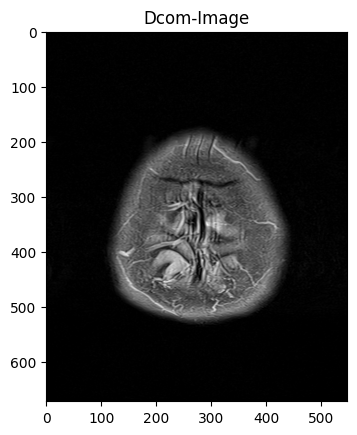

In [85]:

import SimpleITK as sitk
import matplotlib.pyplot as plt

# Read DICOM directly with SimpleITK
dcm = sitk.ReadImage('/content/drive/MyDrive/DCM_Image/IMG-0002-00001.dcm')
image = sitk.GetArrayFromImage(dcm)  # Now this works!
print(f"Image shape: {image.shape}")
plt.imshow(image[0],cmap='gray')
plt.title("Dcom-Image")
plt.show()


In [86]:
##Extracting the medadata
print(f"Patiend ID:{dcm.GetMetaData('0010|0020')}")

Patiend ID:Ultra_fast_Brain


In [87]:
##Using Numpy STL
!pip install numpy-stl

In [88]:
import nibabel as nib;
import numpy as np
from stl import mesh

In [89]:
nii_file_path='/content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0.zip'
!unzip '/content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0.zip'


unzip:  cannot find or open /content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0.zip, /content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0.zip.zip or /content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0.zip.ZIP.


In [95]:
file_path='/content/drive/MyDrive/BraTS20_Training_003_flair.nii'
nifi_file=nib.load(file_path)
np_array=nifi_file.get_fdata()

In [97]:
from skimage import measure
import numpy as np
from stl import mesh  # Import the mesh module correctly

# Your marching cubes
verts, faces, normals, values = measure.marching_cubes(np_array, 0)

# Create the mesh
object_3d = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))

# Fill the mesh data
for i, f in enumerate(faces):
    for j in range(3):
        object_3d.vectors[i][j] = verts[f[j], :]

# Save
object_3d.save('output.stl')


In [102]:
!pip install itk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 54.5 MB/s eta 0:00:00


In [103]:
##ITK file for Medical Imaging
import  itk
import matplotlib.pyplot as plt


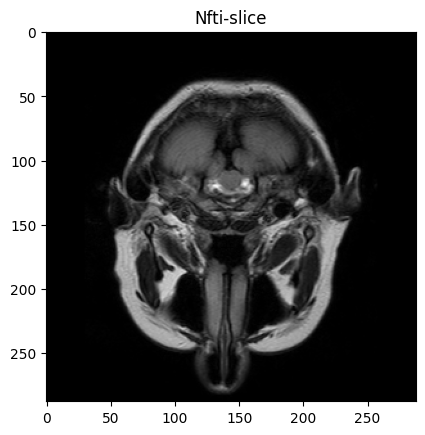

In [108]:
Nii_path='/content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0/BRAINIX/nii/BraTS20_Training_003_flair.nii'
gz_path='/content/drive/MyDrive/3D_HealthCare_Imaging/Dataset1/Neurohacking_data-0.0/BRAINIX/gz/BRAINIX_NIFTI_FLAIR.nii.gz'
image=itk.imread(gz_path)
array=itk.array_from_image(image)
plt.imshow(array[0],cmap='gray')
plt.title("Nfti-slice")
plt.show()


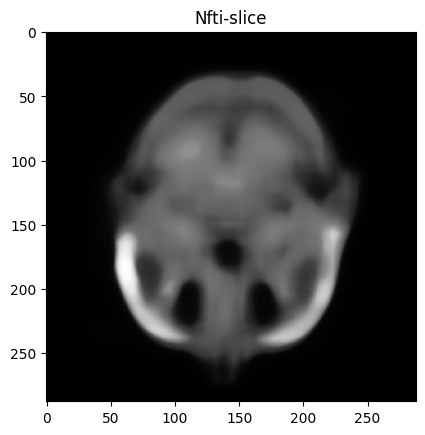

In [111]:
smootherd_image=itk.median_image_filter(image,radius=9)
itk.imwrite(smootherd_image,'/content/drive/MyDrive/3D_HealthCare_Imaging/smoothed_image.nii.gz')


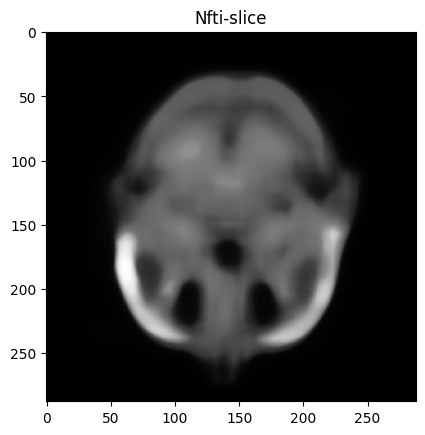

In [112]:
smoothImagePath='/content/drive/MyDrive/3D_HealthCare_Imaging/smoothed_image.nii.gz'
image=itk.imread(smoothImagePath)
array=itk.array_from_image(image)
plt.imshow(array[0],cmap='gray')
plt.title("Nfti-slice")
plt.show()

In [113]:
##Using Monai
!pip install Monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.2 MB/s eta 0:00:00
